In [1]:
import pandas as pd
import numpy as np
import os, gc, math, sys, re
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import *
from geopy.distance import vincenty
from datetime import datetime as dt
from datetime import datetime, timedelta
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import tabulate as t
import holidays as h

In [50]:
from matplotlib import rc
rc('font',**{'family':'Droid Sans'})

Data fields

- PID - patient ID (unique for each patient)
- EID - exam ID (unique for each patient visit)
- Modality - scanner name (MR1 or MR2)
- Exam - exam name (abbreviated). Corresponds to a particular type of scaning (exam)
- Scheduled - time when the exam was scheduled
- Arrive - time when the patient arrived for this exam
- Begin, Complete - time when exam started/ended
- Scan start - time when scanner started scanning (should be after Begin, but before Complete)
- In PACS - time when the exam was sent to the hospital PACS (Picture Archiving and Communication System) - digital archive of medical images.

Datetime format: MM/DD/YY HH:MM

Scheduled, Arrive, Begin and Complete timestamps are entered manually and may contain errors.



In [37]:
df = pd.read_excel('MRIDataOneYear.xlsx')

In [40]:
df.shape

(5546, 10)

In [53]:
sum(df.Begin != df['Scan start'])

0

In [54]:
sum(df.Complete != df['In PACS'])

0

In [41]:
df.columns

Index(['PID', 'EID', 'Modality', 'Exam', 'Scheduled', 'Arrive', 'Begin',
       'Scan start', 'Complete', 'In PACS'],
      dtype='object')

In [42]:
print(min(df.Arrive))
print(max(df.Arrive))

2014-04-07 06:48:00
2015-04-10 17:49:00


- очень странно, почему все секунды обрезаны? это дата в Excel или особенности HIS?

In [ ]:
datetime.weekday

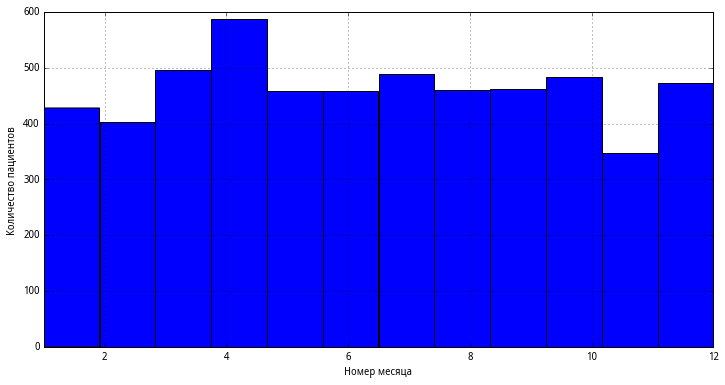

In [59]:
plt.figure(figsize=[12,6])
a = plt.hist(list(map(lambda x: x.month, df.Scheduled)),bins = 12,range = [1,12])
plt.xlim([1,12])
plt.grid(True)
plt.xlabel('Номер месяца')
plt.ylabel('Количество пациентов')

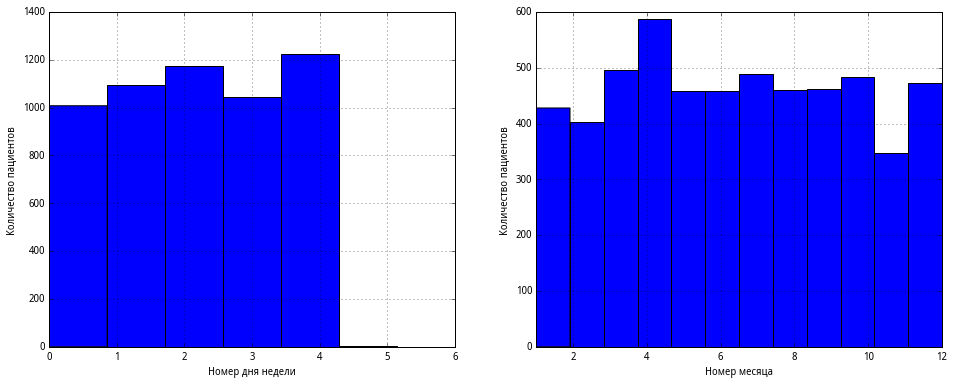

In [77]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.weekday(), df.Scheduled)),bins = 7,range = [0,6],)
plt.xlabel('Номер дня недели')
plt.ylabel('Количество пациентов')
plt.xlim([0,6])
plt.grid(True)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.month, df.Scheduled)),bins = 12,range = [1,12])
plt.xlim([1,12])
plt.grid(True)
plt.xlabel('Номер месяца')
plt.ylabel('Количество пациентов')

In [80]:
df

,PID,EID,Modality,Exam,Scheduled,Arrive,Begin,Scan start,Complete,In PACS,time_of_procedure,time_of_expected
0,3406937,24849519,MR2,MRISPECT,2014-04-07 07:45:00,2014-04-07 06:48:00,2014-04-07 07:15:00,2014-04-07 07:15:00,2014-04-07 08:27:00,2014-04-07 08:27:00,4320.0,1620.0
1,4171966,24144614,MR1,MRILIVWWO,2014-04-07 07:45:00,2014-04-07 07:04:00,2014-04-07 07:48:00,2014-04-07 07:48:00,2014-04-07 08:39:00,2014-04-07 08:39:00,3060.0,2640.0
2,6169209,24855775,MR2,MRISHDW,2014-04-07 08:10:00,2014-04-07 07:46:00,2014-04-07 08:33:00,2014-04-07 08:33:00,2014-04-07 09:17:00,2014-04-07 09:17:00,2640.0,2820.0
3,6141059,24869341,MR1,MRILSNWWO,2014-04-07 08:30:00,2014-04-07 08:19:00,2014-04-07 08:54:00,2014-04-07 08:54:00,2014-04-07 09:44:00,2014-04-07 09:44:00,3000.0,2100.0
4,4425183,24837262,MR2,MRITSBWWO,2014-04-07 09:15:00,2014-04-07 08:28:00,2014-04-07 09:27:00,2014-04-07 09:27:00,2014-04-07 10:21:00,2014-04-07 10:21:00,3240.0,3540.0
5,5674201,24371329,MR1,MRILIVWWO,2014-04-07 10:00:00,2014-04-07 08:41:00,2014-04-07 10:44:00,2014-04-07 10:44:00,2014-04-07 11:20:00,2014-04-07 11:20:00,2160.0,7380.0
6,4603293,24863415,MR1,MRIHIPW,2014-04-07 09:10:00,2014-04-07 08:52:00,2014-04-07 09:45:00,2014-04-07 09:45:00,2014-04-07 10:24:00,2014-04-07 10:24:00,2340.0,3180.0
7,3228313,24787758,MR2,MRIBRNWO,2014-04-07 10:00:00,2014-04-07 09:16:00,2014-04-07 10:27:00,2014-04-07 10:27:00,2014-04-07 10:54:00,2014-04-07 10:54:00,1620.0,4260.0
8,4008556,24848251,MR2,MRIGYNWWO,2014-04-07 10:40:00,2014-04-07 09:23:00,2014-04-07 11:24:00,2014-04-07 11:24:00,2014-04-07 12:19:00,2014-04-07 12:19:00,3300.0,7260.0
9,6065553,24254963,MR2,MRIBRNWWO,2014-04-07 11:30:00,2014-04-07 09:59:00,2014-04-07 11:46:00,2014-04-07 11:46:00,2014-04-07 12:16:00,2014-04-07 12:16:00,1800.0,6420.0


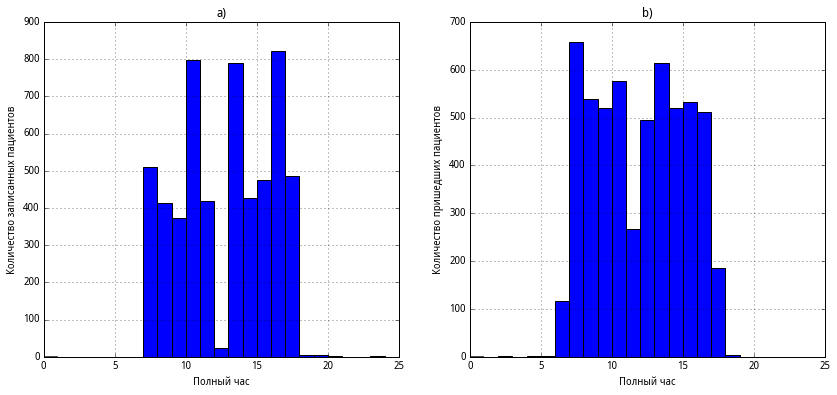

In [79]:
plt.figure(figsize=[14,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.title('a)')
plt.xlabel('Полный час')
plt.ylabel('Количество записанных пациентов')
plt.grid(True)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.title('b)')
plt.xlabel('Полный час')
plt.ylabel('Количество пришедших пациентов')
plt.grid(True)

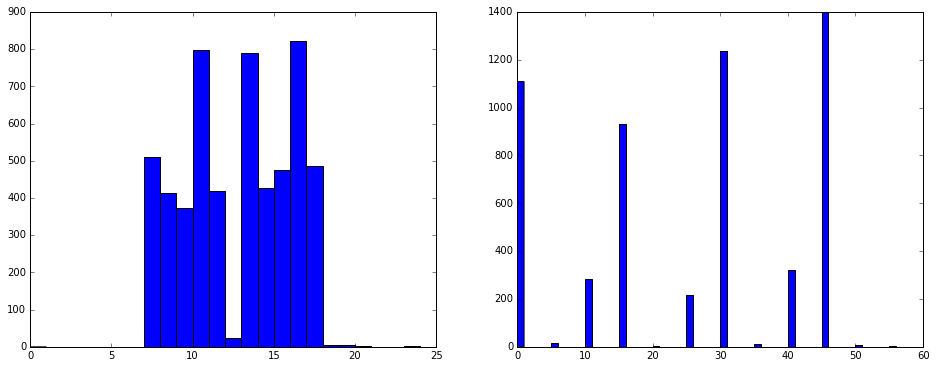

In [3]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Scheduled)),bins = 60,range = [0,60])

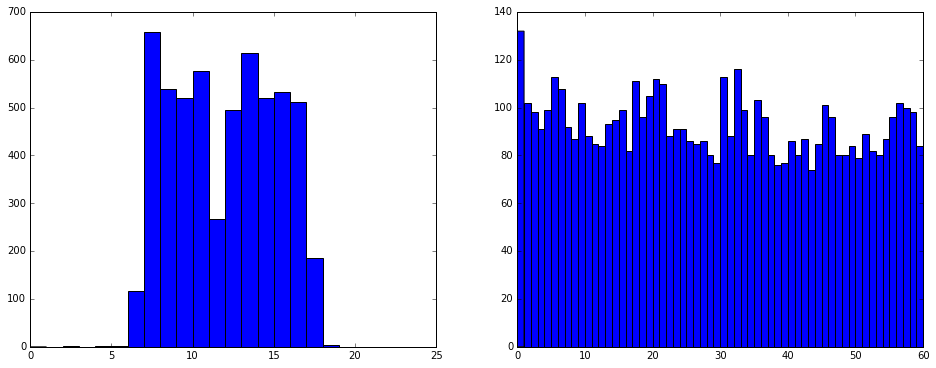

In [4]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Arrive)),bins = 60,range = [0,60])

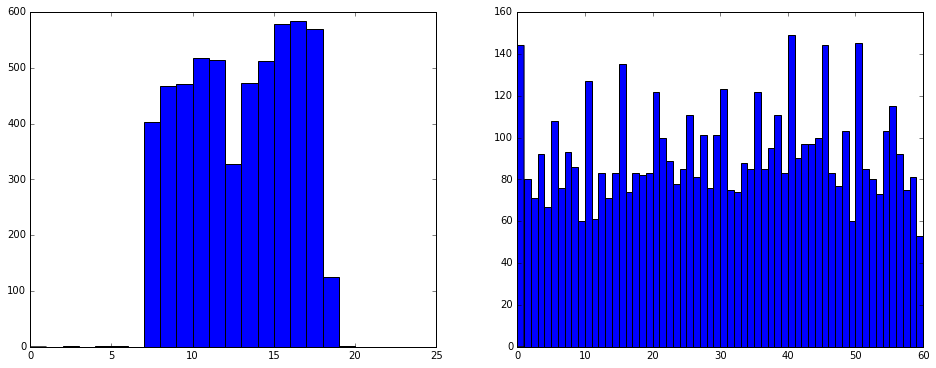

In [5]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Begin)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Begin)),bins = 60,range = [0,60])

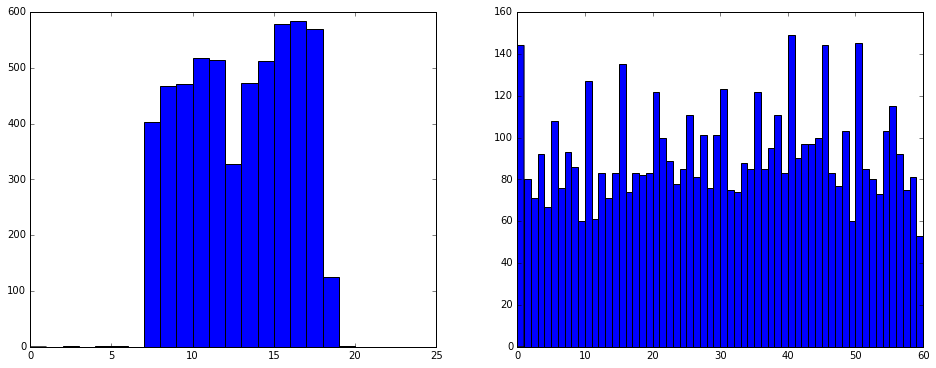

In [6]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['Scan start'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['Scan start'])),bins = 60,range = [0,60])

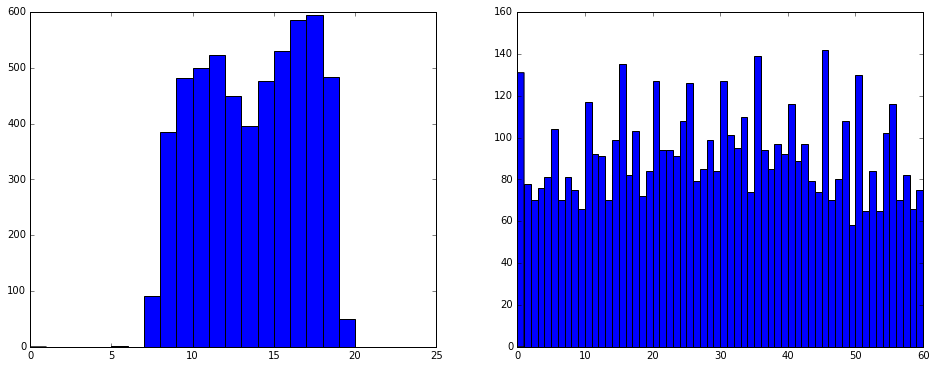

In [7]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Complete)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Complete)),bins = 60,range = [0,60])

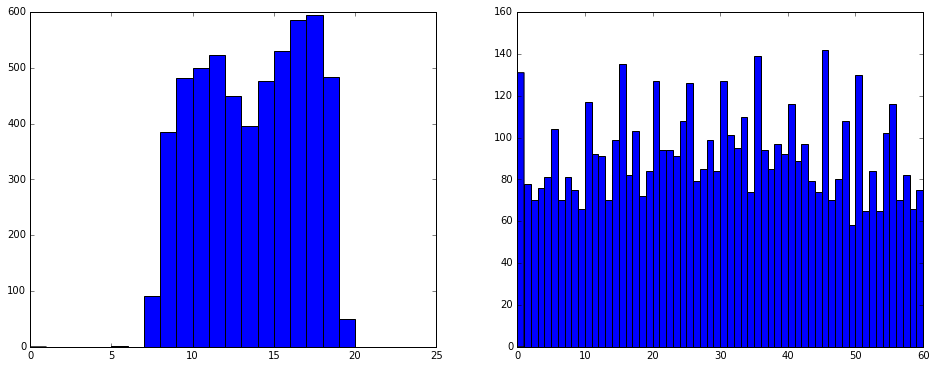

In [8]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['In PACS'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['In PACS'])),bins = 60,range = [0,60])

In [9]:
sum(df['Begin'] > df['Scan start'])

0

In [10]:
sum(df['Scan start'] > df['Complete'])

0

# В этом блоке я буду реализовывать функции для вытягивания фичей

In [4]:
unix_date = datetime(2010, 1, 1,0,0,0)
td = timedelta(seconds=1)
for i in ['Scheduled', 'Arrive', 'Begin','Scan start', 'Complete', 'In PACS']:
    df[i+'_UNIX'] = list(map(lambda x: (x - unix_date) /  td, df[i]))

In [5]:
day = datetime.strptime('02.10.10','%d.%m.%y') - datetime.strptime('01.10.10','%d.%m.%y')
week = datetime.strptime('17.10.10 10:10:10','%d.%m.%y %H:%M:%S') - datetime.strptime('10.10.10 10:10:10','%d.%m.%y %H:%M:%S')
month = datetime.strptime('01.10.10','%d.%m.%y') - datetime.strptime('01.09.10','%d.%m.%y')

In [73]:
# время ожидания от прихода

# TARGET

def time_of_expected(df):
    df['time_of_expected'] = df.Begin - df.Arrive
    df['time_of_expected'] = list(map(lambda x: x.delta/1000000000,tqdm(df['time_of_expected'])))
    return df

In [7]:
# добавить дамии на месяц (но сейчас у нас эта штука не будет иметь значение (по идее) так как мы используем как тест один обособленный месяц)
df['month'] = list(map(lambda x: x.month, df.Arrive))

In [8]:
# добавить дамми на день недели
df['day_of_week'] = list(map(lambda x: datetime.weekday(x), df.Arrive))

In [ ]:
# изменить года для нового датасета
us_hol = h.US(state='MA', years=[2013,2014,2015])
# добавить расстояние до ближайщего справа праздника
def right(x, hol = us_hol):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.min(pd.Series(days)[pd.Series(days) >= 0])
    return day
df['right_holiday'] = list(map(lambda x: right(x), tqdm(df.Arrive)))
# добавить расстояние до ближайщего слева праздника
def left(x):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.max(pd.Series(days)[pd.Series(days) <= 0])
    return day
df['left_holiday'] = list(map(lambda x: left(x), tqdm(df.Arrive)))
                          
df['is_holiday'] = list(map(lambda x: int(x in us_hol), df.Arrive))

 73%|███████▎  | 4028/5546 [00:04<00:01, 921.53it/s]

In [21]:
def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    #y_true, y_pred = check_array(y_true, y_pred)
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred)) / pd.Series(y_true).astype(float))) * 100
def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])

In [ ]:
# время ожидание от запланированного приема (может быть отрицательным)

def time_of_expected_on_shedule(df):
    df['time_of_expected_on_shedule'] = df.Begin - df.Scheduled
    df['time_of_expected_on_shedule'] = list(map(lambda x: x.delta/1000000000,df['time_of_expected_on_shedule']))
    return df

In [62]:
# сколько выполнялось исследование (может быть оооочень большим)

def time_of_procedure(df):
    df['time_of_procedure'] = df['Complete'] - df['Begin']
    df['time_of_procedure'] = list(map(lambda x: x.delta/1000000000,df['time_of_procedure']))
    return df

In [ ]:
# сколько пациентов находилось в очереди за delta секунд

def lq(x,y,delta = 0, df = df):
    return df[(df.Arrive_UNIX < x-delta) & (df.Begin_UNIX > x-delta) & (df.Modality == y)].shape[0]
def len_of_queque(df, delta = 0):
    df['len_of_queque_before_'+str(delta)+'_seconds'] = list(map(lambda x, y: lq(x,y,delta,df) , df.Arrive_UNIX, df.Modality))
    return df

In [ ]:
# количество зашедших на исследование за некоторое время

# time_delta в секундах

def come_in(x,df,time_delta):
    return df[(df.Begin_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Begin_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_in(df,time_delta):
    df['count_who_come_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_in(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [ ]:
# количество вышедших с исследования за некоторое время

# time_delta в секундах

def come_out(x,df,time_delta):
    return df[(df.Complete_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Complete_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_out(df,time_delta):
    df['count_who_come_out_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_out(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [ ]:
# количество пришедших в госпиталь за некоторое время

# time_delta в секундах

def arrive_in(x,df,time_delta):
    return df[(df.Arrive_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Arrive_UNIX <= (x - unix_date)/td )].shape[0]

def count_who_arrive_in(df,time_delta):
    df['count_who_arrive_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: 
            arrive_in(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [ ]:
# среднее время ожидания по всем людям, которые пришли за некоторый промежуток времени

def mean_time(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected)
def mean_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение по всем людям, которые пришли за некоторый промежуток времени

def std_time(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected)
def std_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [ ]:
# среднее время проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def mean_time_2(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_procedure)
def mean_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def std_time_2(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_procedure)
def std_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [ ]:
# среднее время отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def mean_time_3(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def mean_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def std_time_3(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def std_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [ ]:
# чувак с какой модальностью сейчас на исследовании

def closest_modality(df):
    return modality
def now_with_doctor(df):
    df['now_with_doctor'] = list(map(lambda x: closest_modality(df[(df.Modality == y) & (df.Begin_UNIX < x)]), df.Begin_UNIX, df.Modality ))
    return df

In [ ]:
# посмотреть распределение модальностей для тех ребят, которые сейчас внутри

In [ ]:
# разница во времени между пришедшим сейчас и пришедшим перед

In [ ]:
# предсказанное время ожидания для того, кто пришел перед текущим человеком

In [ ]:
# зашел ли тот человек, который пришел перед тобой, в кабинете

In [ ]:
# вышел ли тот человек, который пришел перед тобой, из кабинета

In [75]:
df = time_of_expected(df)

100%|██████████| 5546/5546 [00:00<00:00, 94003.01it/s]


In [ ]:
df = time_of_expected_on_shedule(df)

In [63]:
df = time_of_procedure(df)

In [ ]:
for i in tqdm(range(0,150,10)):
    df = len_of_queque(df,i*60)

In [ ]:
for i in tqdm(range(0,150,10)):
    df = count_who_come_in(df,60*i)

In [ ]:
for i in tqdm(range(0,150,10)):
    df = count_who_arrive_in(df,60*i)

In [ ]:
for i in tqdm(range(1,8)):    
    df = mean_time_of_exp(df,i,day)
    df = std_time_of_exp(df,i,day)
    df = mean_time_of_proced(df,i,day)
    df = std_time_of_proced(df,i,day)
    df = mean_time_of_exp_schel(df,i,day)
    df = std_time_of_exp_schel(df,i,day)

In [ ]:
for i in tqdm(range(8,13)):    
    df = mean_time_of_exp(df,i,day)
    df = std_time_of_exp(df,i,day)
    df = mean_time_of_proced(df,i,day)
    df = std_time_of_proced(df,i,day)
    df = mean_time_of_exp_schel(df,i,day)
    df = std_time_of_exp_schel(df,i,day)

In [80]:
for i in list(df.columns[22:]):
    df[i] = df[i].fillna(0)

In [151]:
def dummie_train(df, col):
    uniq = df[col].unique()
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df, uniq
def dummie_test(df, col, uniq):
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df

In [152]:
for i in tqdm(['Modality','day_of_week','month']):
    df,temp_uniq = dummie_train(df,i)

100%|██████████| 3/3 [00:00<00:00, 39.20it/s]


# Сохраним обновленный датафрэйм в пикл

In [ ]:
df.to_pickle('new_dataFrame_with_features_15_05_16-30.pkl')

# !!!!!!!!!!!!!!!!

# Загрузим из пикла

In [2]:
df = pd.read_pickle('new_dataFrame.pkl')

# Выберем фичи для модели

In [3]:
cols = df.columns[17:20] + df.columns[23:]
cols

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


Index(['Exam_MRAAORWO  ', 'Exam_MRAAORWWO ', 'Exam_MRAARCWO  ',
       'Exam_MRAARCWWO ', 'Exam_MRAASCWWO ', 'Exam_MRAHEDW   ',
       'Exam_MRAHEDWO  ', 'Exam_MRAHEDWWO ', 'Exam_MRALOEWWO ',
       'Exam_MRAMESWWO ',
       ...
       'std_time_of_exp_schel_5_day', 'std_time_of_exp_schel_6_day',
       'std_time_of_exp_schel_7_day', 'std_time_of_proced_1_day',
       'std_time_of_proced_2_day', 'std_time_of_proced_3_day',
       'std_time_of_proced_4_day', 'std_time_of_proced_5_day',
       'std_time_of_proced_6_day', 'std_time_of_proced_7_day'],
      dtype='object', length=216)

In [4]:
cols = df.columns[24:]+df.columns[17:19] 
target = 'time_of_expected'

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


# Выделим тест и трэйн

In [5]:
print(min(df.Arrive))
print(max(df.Arrive))

2014-04-07 06:48:00
2015-04-10 17:49:00


In [6]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [7]:
print(df.shape)
print(df_temp.shape)

(5546, 236)
(5539, 236)


In [8]:
train.shape

(4650, 236)

In [9]:
test.shape

(889, 236)

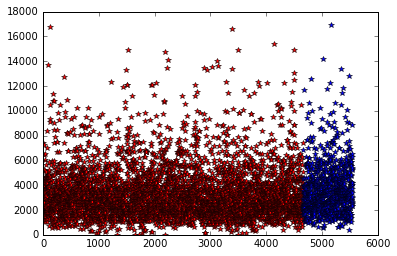

In [10]:
plt.plot(train.time_of_expected,'*r')
plt.plot(test.time_of_expected,'*b')

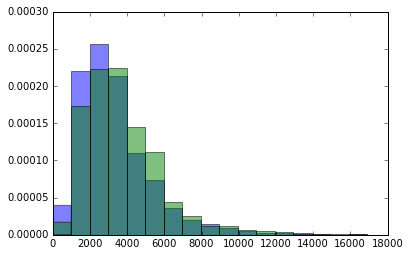

In [11]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.5, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.5)

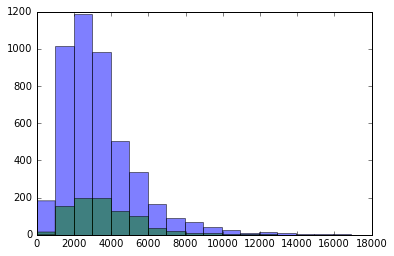

In [12]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.5, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.5)

## C валидационной выборкой

In [27]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
date_threshold_2 = datetime.strptime('15.03.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
val = df_temp[(df_temp.Arrive >= date_threshold_1) & (df_temp.Arrive < date_threshold_2) ]
test = df_temp[df_temp.Arrive >= date_threshold_2]
train = train.sort_values('Arrive')
val = val.sort_values('Arrive')
test = test.sort_values('Arrive')

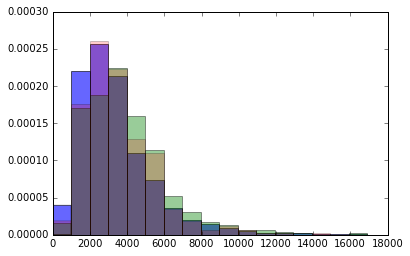

In [28]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.6, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.4)
temp_hist = plt.hist(val.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.2)

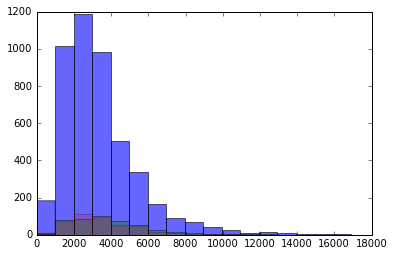

In [29]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.6, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.4)
temp_hist = plt.hist(val.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.2)

# Модели

In [13]:
import sklearn.tree as tree
import sklearn.cross_validation as cv

In [14]:
import sklearn.linear_model as lin

In [15]:
import sklearn.ensemble as ens

In [16]:
model = ens.GradientBoostingRegressor()

In [17]:
model = lin.ARDRegression()

In [18]:
temp = df.describe()

In [19]:
temp.transpose()

,count,mean,std,min,25%,50%,75%,max
PID,5546.0,4.865914e+06,1.271559e+06,806661.0,4.044286e+06,5175027.0,5.995815e+06,6371099.0
EID,5546.0,2.523297e+07,4.113273e+05,23015976.0,2.496702e+07,25252354.0,2.556467e+07,25915595.0
Scheduled_UNIX,5546.0,1.503558e+08,9.382725e+06,134552700.0,1.424347e+08,150026400.0,1.585030e+08,166383900.0
Arrive_UNIX,5546.0,1.503526e+08,9.383465e+06,134549280.0,1.424341e+08,150022650.0,1.584998e+08,166384140.0
Begin_UNIX,5546.0,1.503561e+08,9.383572e+06,134550900.0,1.424358e+08,150025410.0,1.585016e+08,166386480.0
Scan start_UNIX,5546.0,1.503561e+08,9.383572e+06,134550900.0,1.424358e+08,150025410.0,1.585016e+08,166386480.0
Complete_UNIX,5546.0,1.503588e+08,9.383585e+06,134555220.0,1.424379e+08,150028350.0,1.585044e+08,166388400.0
In PACS_UNIX,5546.0,1.503588e+08,9.383585e+06,134555220.0,1.424379e+08,150028350.0,1.585044e+08,166388400.0
day_of_week,5546.0,2.070141e+00,1.412281e+00,0.0,1.000000e+00,2.0,3.000000e+00,5.0
right_holiday,5546.0,1.750415e+01,1.227831e+01,0.0,8.000000e+00,16.0,2.500000e+01,56.0


# Линейная регрессия

In [24]:
from sklearn.metrics import mean_squared_error

quality-L1  0.3389137693305045
R^2  0.198190264038
mape  39.06971223055431
mse 3532725.396177
mean diff in minute  4.722103301884192
***


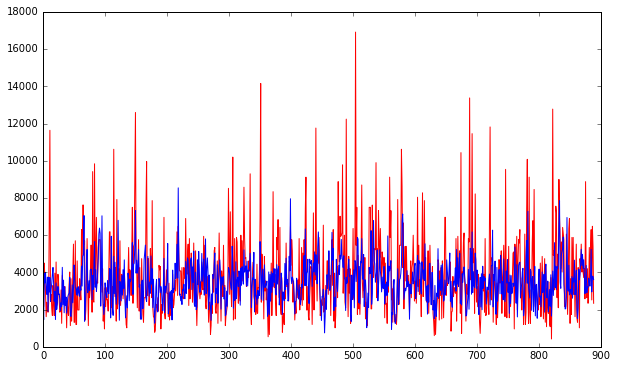

In [25]:
model = lin.LinearRegression(fit_intercept=True)
model.fit(train[cols],train[target].values)
res = model.predict(test[cols])
print('quality-L1 ',quality(test[target].values, res))
print('R^2 ',model.score(test[cols],test[target].values))
print('mape ',mape(list(test[target].values), list(res)))
print('mse %f'% mean_squared_error(list(test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(test[target].values) - pd.Series(res))/60))
print('***')
plt.figure(figsize=[10,6])
plt.plot(test[target].values,'r')
plt.plot(res,'b')

## Попробуем добавлять фичи по очереди
## Посмотрим, как уменьшается ошибка

50.30462482417042   std_time_of_proced_7_day
50.3944841223554   std_time_of_proced_6_day
50.33417006171214   std_time_of_proced_5_day
50.31832324629585   std_time_of_proced_4_day
50.25194650016339   std_time_of_proced_3_day
50.17548101492078   std_time_of_proced_2_day
50.12491637930287   std_time_of_proced_1_day
50.11918841166442   std_time_of_exp_schel_7_day
50.119407639832815   std_time_of_exp_schel_6_day
50.12204946767979   std_time_of_exp_schel_5_day
50.12034007278216   std_time_of_exp_schel_4_day
50.12132261202167   std_time_of_exp_schel_3_day
50.11983306029057   std_time_of_exp_schel_2_day
50.12243295557796   std_time_of_exp_schel_1_day
49.811846281740884   std_time_of_exp_7_day
49.824893096170044   std_time_of_exp_6_day
49.80427966492041   std_time_of_exp_5_day
49.83782590905567   std_time_of_exp_4_day
49.86689533187151   std_time_of_exp_3_day
49.913569042160006   std_time_of_exp_2_day
49.97287543787332   std_time_of_exp_1_day
49.37851462987099   right_holiday
50.26086924459211 

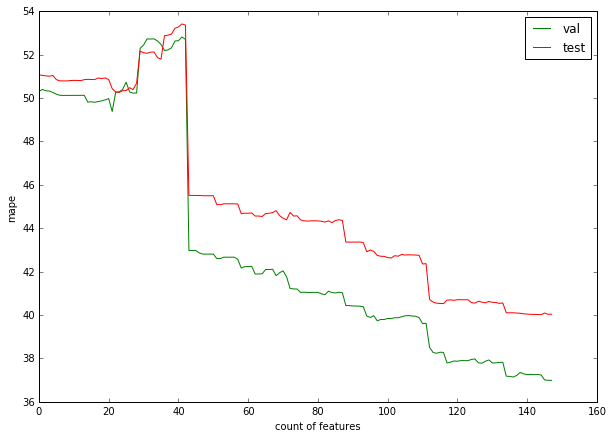

In [36]:
our_features = list(df.columns[24:170])+list(df.columns[17:19] )
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,mape(list(val[target].values), list(res)))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,mape(list(test[target].values), list(res_test)))])
    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    print(L1_s[0][1],' ',L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('mape')
plt.xlabel('count of features')
ax.legend()

0.3965050752693725   std_time_of_proced_7_day
0.39708952633944933   std_time_of_proced_6_day
0.396937429616045   std_time_of_proced_5_day
0.39692193525400427   std_time_of_proced_4_day
0.3965227692943785   std_time_of_proced_3_day
0.396282593133919   std_time_of_proced_2_day
0.39599201539471846   std_time_of_proced_1_day
0.3959798081779044   std_time_of_exp_schel_7_day
0.39598354941129704   std_time_of_exp_schel_6_day
0.395985395805838   std_time_of_exp_schel_5_day
0.39602807818144253   std_time_of_exp_schel_4_day
0.3960324233592183   std_time_of_exp_schel_3_day
0.39598028833982274   std_time_of_exp_schel_2_day
0.3962424295065318   std_time_of_exp_schel_1_day
0.395538343432861   std_time_of_exp_7_day
0.39562812351174226   std_time_of_exp_6_day
0.3955719895602866   std_time_of_exp_5_day
0.3959344945470849   std_time_of_exp_4_day
0.3963216948206921   std_time_of_exp_3_day
0.3964820540965232   std_time_of_exp_2_day
0.3969100823105689   std_time_of_exp_1_day
0.3956329102161545   right_holi

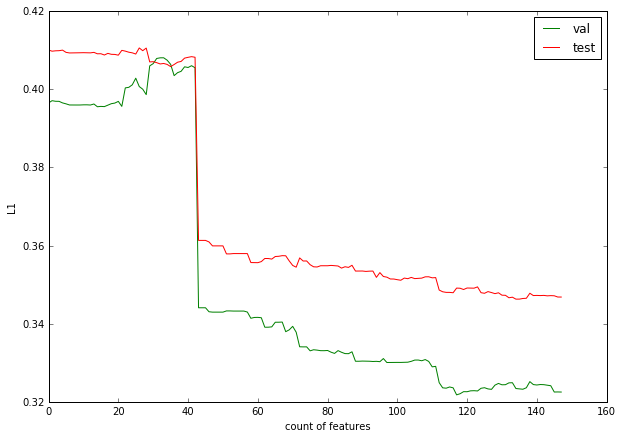

In [32]:
our_features = list(df.columns[24:170])+list(df.columns[17:19] )
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,quality(val[target].values, res))])
        res = model.predict(test[using_features+[j]])
        L1_test.update([(j,quality(test[target].values, res))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('L1')
plt.xlabel('count of features')
ax.legend()

In [33]:
import sklearn.metrics as metrics

3825301.84389   std_time_of_proced_7_day
3831173.59952   std_time_of_proced_6_day
3831413.25599   std_time_of_proced_5_day
3831860.95871   std_time_of_proced_4_day
3831361.26723   std_time_of_proced_3_day
3830277.00066   std_time_of_proced_2_day
3829220.04203   std_time_of_proced_1_day
3829307.72624   std_time_of_exp_schel_7_day
3829463.39029   std_time_of_exp_schel_6_day
3829346.41161   std_time_of_exp_schel_5_day
3831040.4802   std_time_of_exp_schel_4_day
3830964.03977   std_time_of_exp_schel_3_day
3829385.60602   std_time_of_exp_schel_2_day
3838038.84246   std_time_of_exp_schel_1_day
3848656.667   std_time_of_exp_7_day
3849487.22634   std_time_of_exp_6_day
3850519.17971   std_time_of_exp_5_day
3855494.14826   std_time_of_exp_4_day
3859342.27217   std_time_of_exp_3_day
3859469.4924   std_time_of_exp_2_day
3858854.75136   std_time_of_exp_1_day
3865188.54285   right_holiday
3918489.3176   mean_time_of_proced_7_day
3920142.77937   mean_time_of_proced_6_day
3921181.70649   mean_time_of_p

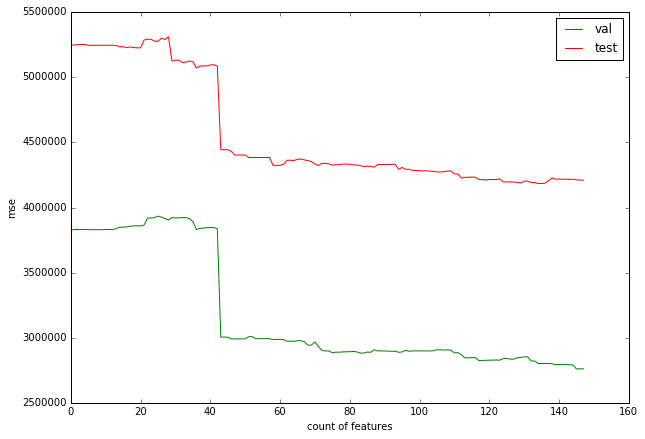

In [34]:
our_features = list(df.columns[24:170])+list(df.columns[17:19] )
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,metrics.regression.mean_squared_error(val[target].values, res))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,metrics.regression.mean_squared_error(test[target].values, res_test))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('mse')
plt.xlabel('count of features')
ax.legend()


3.39536617930834   std_time_of_proced_7_day
3.37484710745986   std_time_of_proced_6_day
3.4245299087098227   std_time_of_proced_5_day
3.438482601839738   std_time_of_proced_4_day
3.4581637627370783   std_time_of_proced_3_day
3.5313143128707765   std_time_of_proced_2_day
3.5702725391100243   std_time_of_proced_1_day
3.5750780203174357   std_time_of_exp_schel_7_day
3.5757877269535348   std_time_of_exp_schel_6_day
3.5712414081554424   std_time_of_exp_schel_5_day
3.582439403829894   std_time_of_exp_schel_4_day
3.582406829879539   std_time_of_exp_schel_3_day
3.574215665725738   std_time_of_exp_schel_2_day
3.62020303922821   std_time_of_exp_schel_1_day
3.9003897436883954   std_time_of_exp_7_day
3.8991571845298365   std_time_of_exp_6_day
3.9737152942645593   std_time_of_exp_5_day
4.019902432178676   std_time_of_exp_4_day
4.081112335212141   std_time_of_exp_3_day
4.043657730130976   std_time_of_exp_2_day
4.026569197124795   std_time_of_exp_1_day
4.495192340988639   right_holiday
4.316037029989

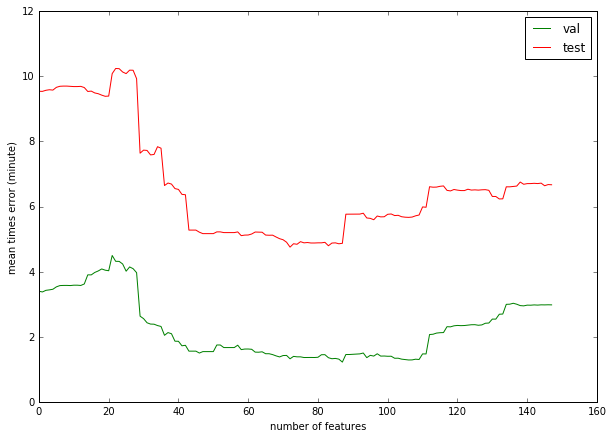

In [35]:
our_features = list(df.columns[24:170])+list(df.columns[17:19] )
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        #L1.update([(j,np.mean((pd.Series(np.abs(val[target].values) - pd.Series(res)))/60))])
        L1.update([(j,np.mean((pd.Series(val[target].values) - pd.Series(res))/60))])
        res_test = model.predict(test[using_features+[j]])
        #L1_test.update([(j,np.mean(np.abs(pd.Series(test[target].values) - pd.Series(res_test))/60))])
        L1_test.update([(j,np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('mean times error (minute)')
plt.xlabel('number of features')
ax.legend()


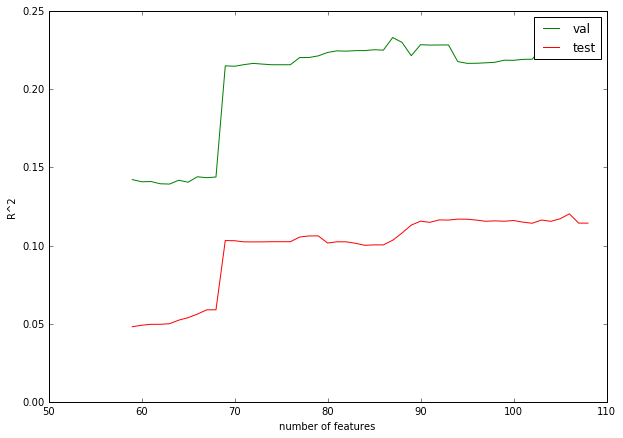

In [250]:
our_features = list(df.columns[24:170])+list(df.columns[17:19] )
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,metrics.r2_score(val[target].values,res))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,metrics.r2_score(test[target].values,res_test))])
    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(pd.Series(Q)[pd.Series(Q) >0],'g',label = 'val')
ax.plot(pd.Series(Q_test)[pd.Series(Q_test) >0],'r',label = 'test')
plt.ylabel('R^2')
plt.xlabel('number of features')
ax.legend()

# Байесовская регрессия

In [253]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [254]:
from sklearn.linear_model import BayesianRidge, LinearRegression

quality-L1  0.340315957625541
R^2  0.172781069707
mape  40.938549948718894
mean diff in minute  4.652633493463801


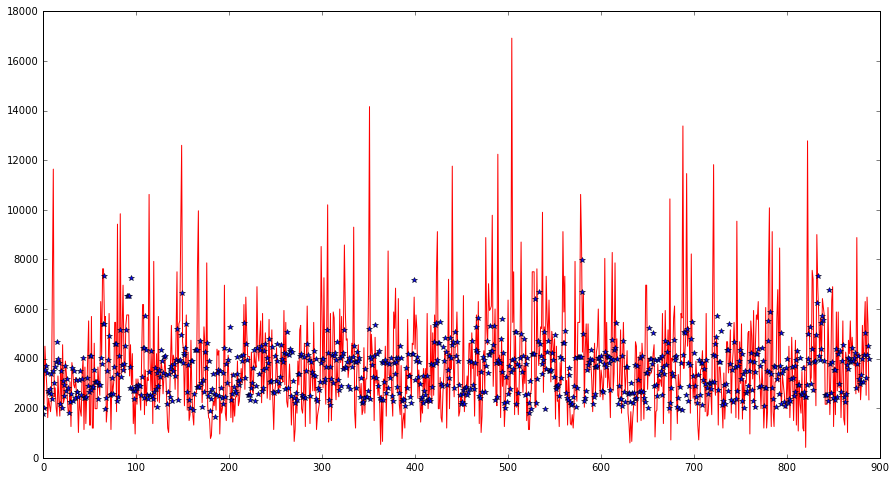

In [255]:
clf = BayesianRidge(n_iter=100, tol=0.0001, alpha_1=1e-8, alpha_2=1e-10, lambda_1=1e-5, lambda_2=1e8,normalize=True)
clf.fit(train[cols],train[target].values)
res = clf.predict(test[cols])
print('quality-L1 ',quality(test[target].values, res))
#print(test[cols].shape)
#print(len(test[target].values))
print('R^2 ',clf.score(test[cols],test[target].values))
print('mape ',mape(list(test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(test[target].values) - pd.Series(res))/60))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(res,'*b')

# Деревья (не показали должного результата)

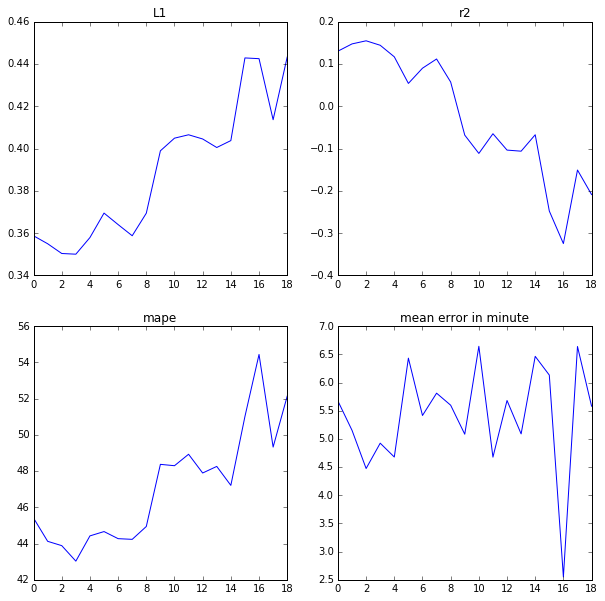

In [391]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []

for md in range(1,20):
    model = tree.ExtraTreeRegressor(max_depth=md,min_samples_leaf=5,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(test[cols])
    t_1.append(quality(test[target].values, res))
    t_2.append(model.score(test[cols],test[target].values))
    t_3.append((mape(list(test[target].values), list(res))))
    t_4.append(np.mean((pd.Series(test[target].values) - pd.Series(res))/60))

plt.subplot(221)
plt.plot(t_1)
plt.title('L1')
plt.subplot(222)
plt.plot(t_2)
plt.title('r2')
plt.subplot(223)
plt.plot(t_3)
plt.title('mape')
plt.subplot(224)
plt.plot(t_4)
plt.title('mean error in minute')

1
quality-L1  0.3744760284325683
R^2  0.0618450025883
mape  45.74236260930785
mean diff in minute  6.705697549556507
***
2
quality-L1  0.3687981576436608
R^2  0.0907762791522
mape  45.357630055107315
mean diff in minute  6.260665274857148
***
3
quality-L1  0.3546986432977055
R^2  0.130238311535
mape  43.49930666429431
mean diff in minute  5.267793437900098
***
4
quality-L1  0.35703335723352597
R^2  0.134703911094
mape  44.03621947147643
mean diff in minute  5.025044485541821
***
5
quality-L1  0.35963204495538953
R^2  0.104249839134
mape  42.58199166019185
mean diff in minute  6.318714622853385
***
6
quality-L1  0.3459089354061836
R^2  0.138516042348
mape  40.98526521222634
mean diff in minute  5.3746215706052345
***
7
quality-L1  0.3493121879432631
R^2  0.130784787399
mape  40.65313891334755
mean diff in minute  7.086080004700984
***
8
quality-L1  0.36465966735319877
R^2  0.0753509533004
mape  42.76404906688813
mean diff in minute  4.927740072969758
***
9
quality-L1  0.3758602164058018

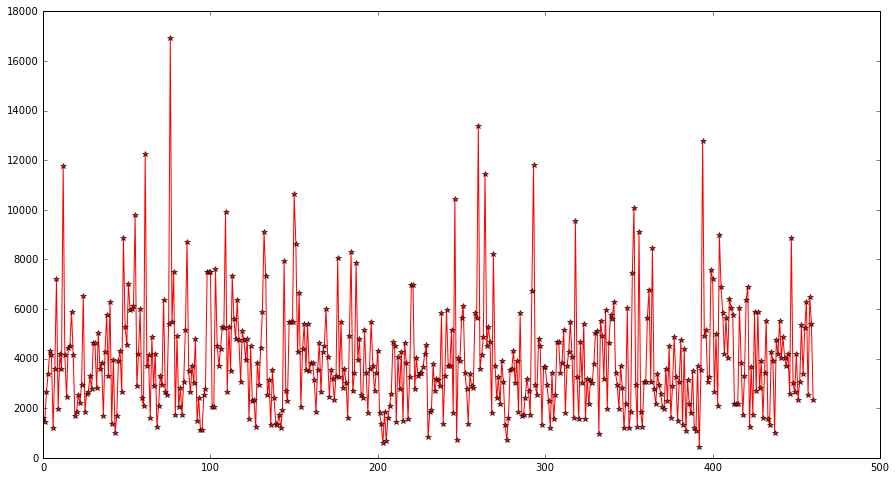

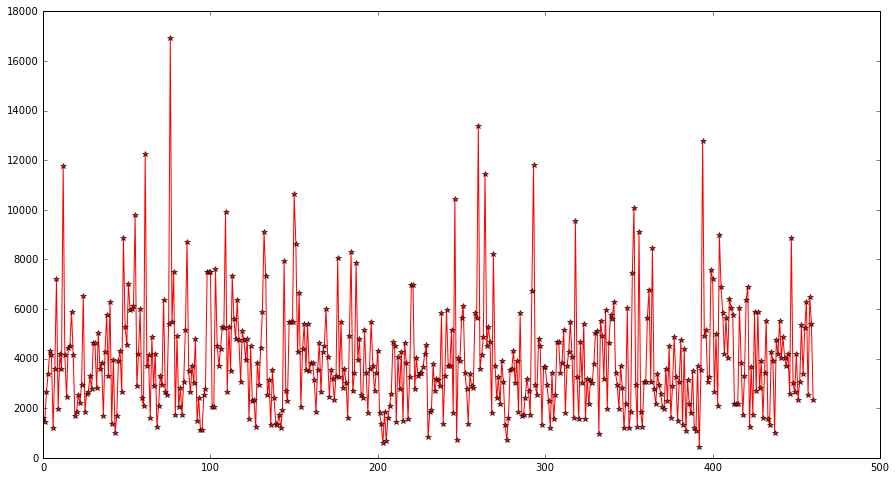

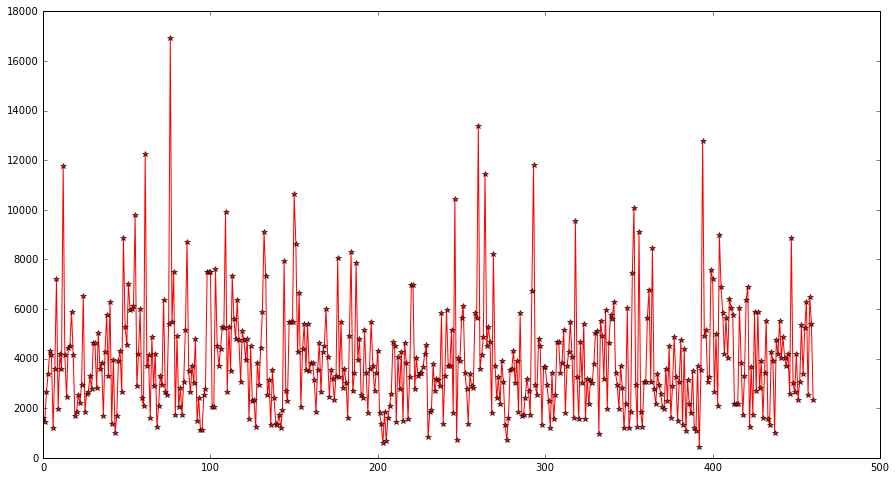

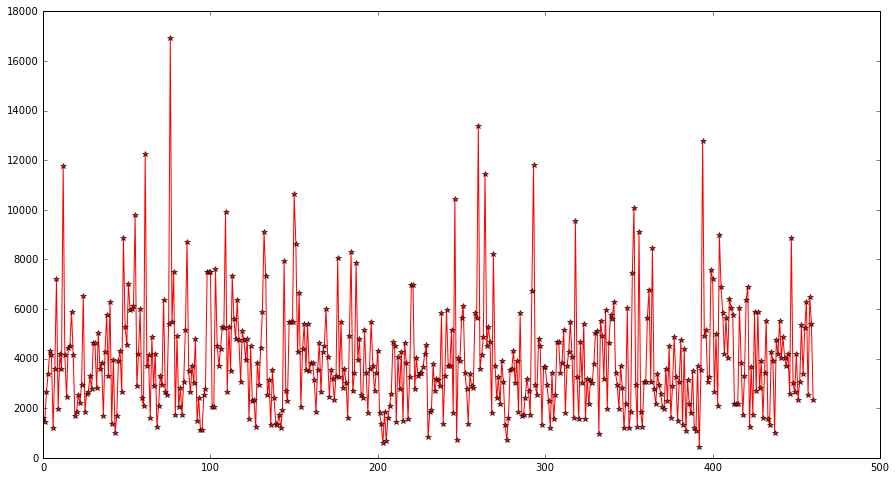

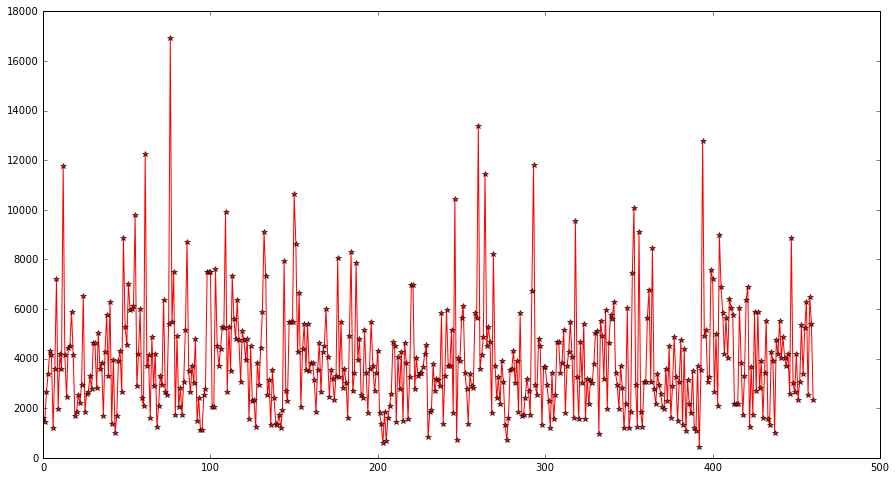

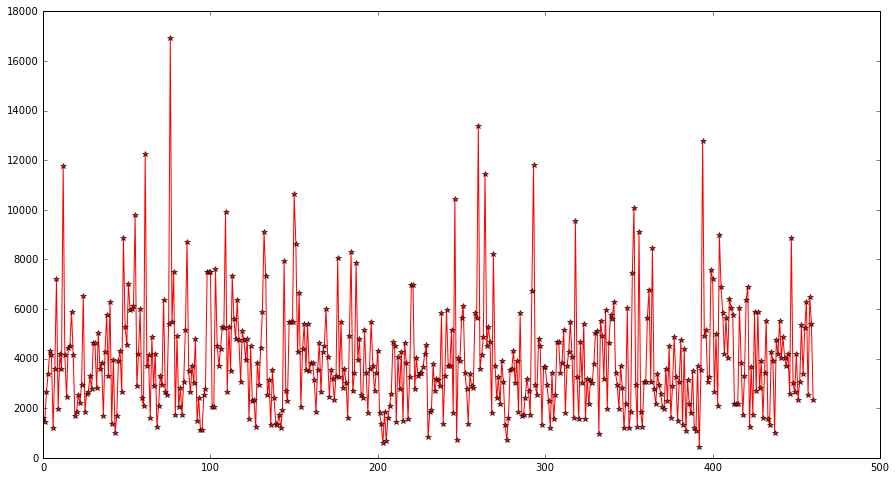

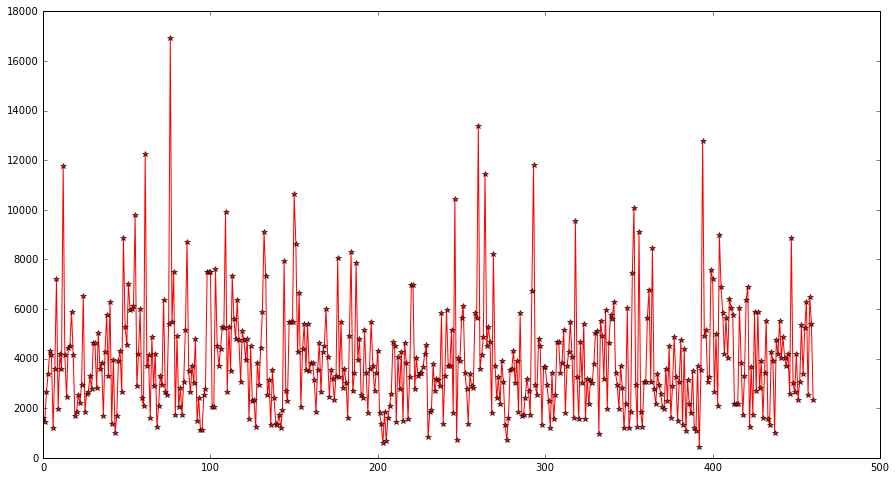

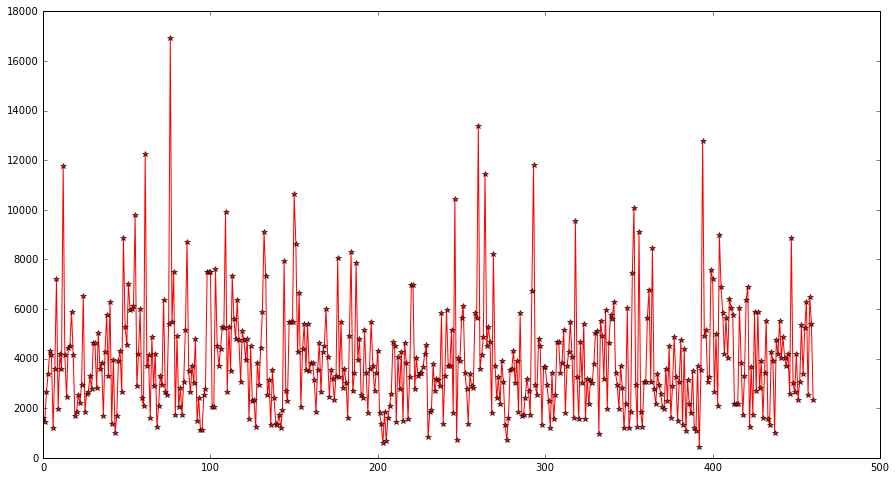

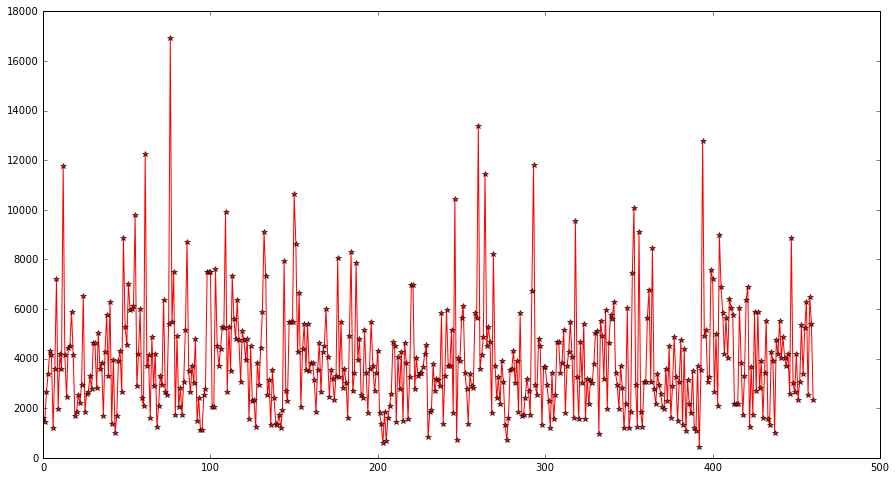

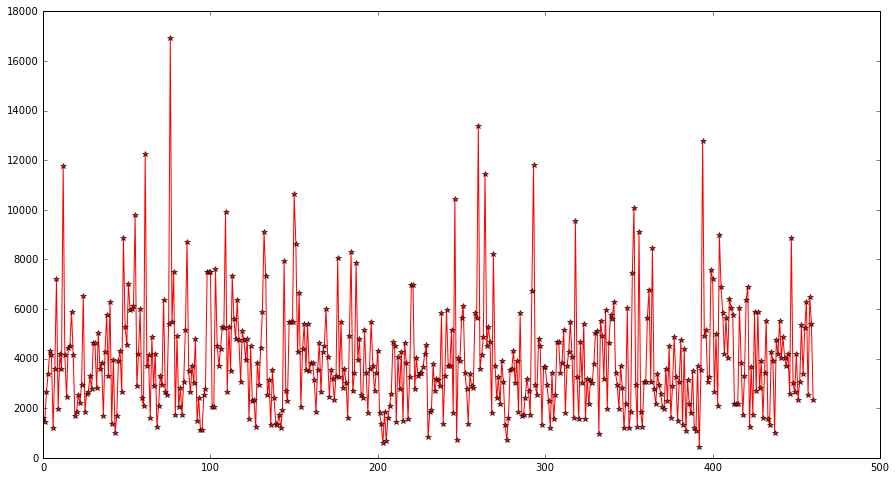

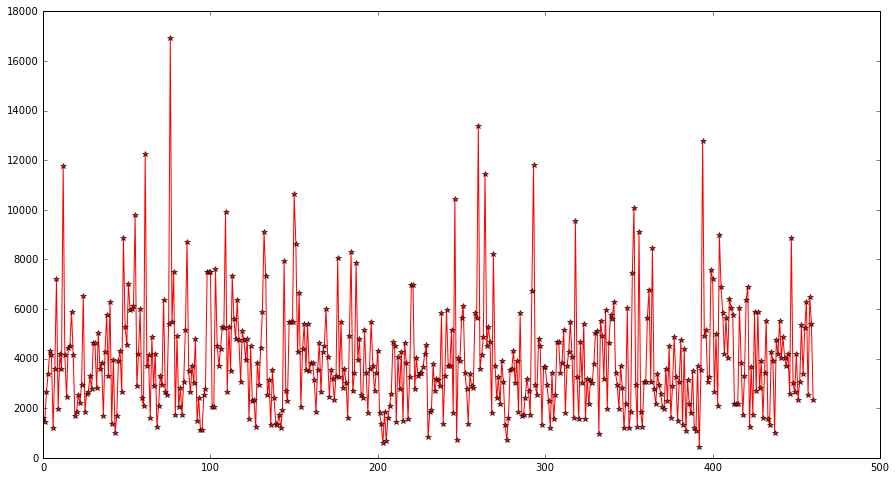

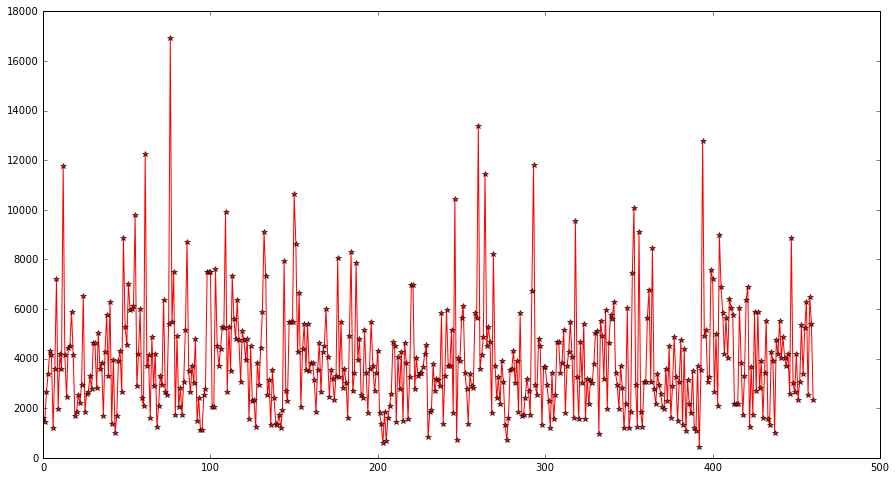

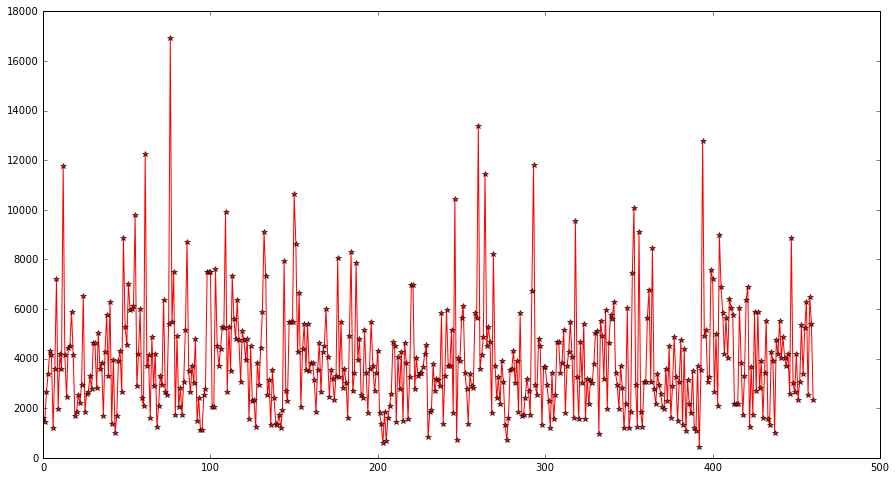

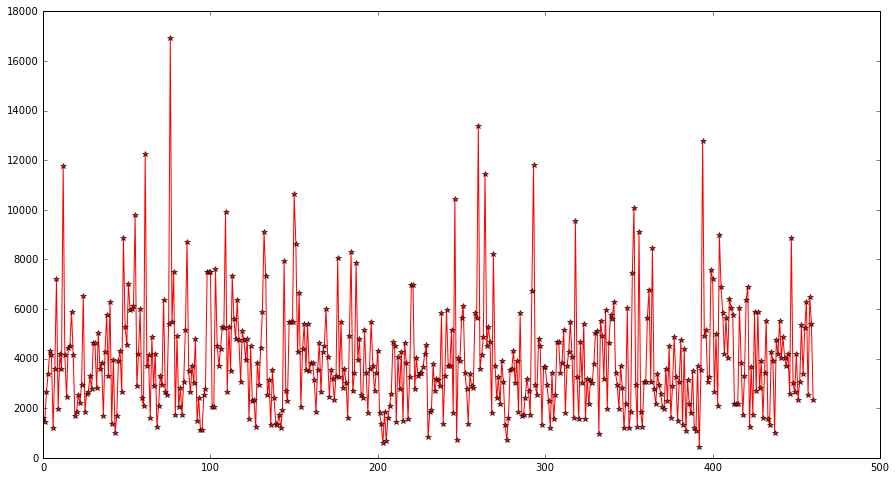

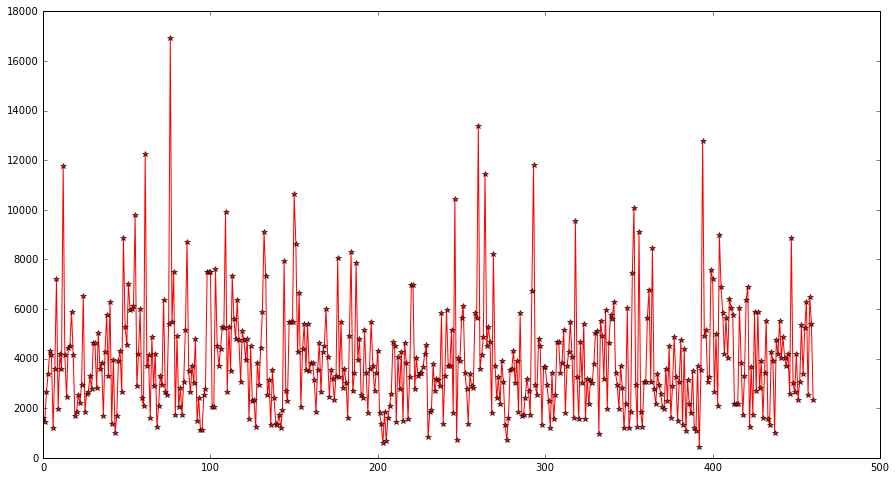

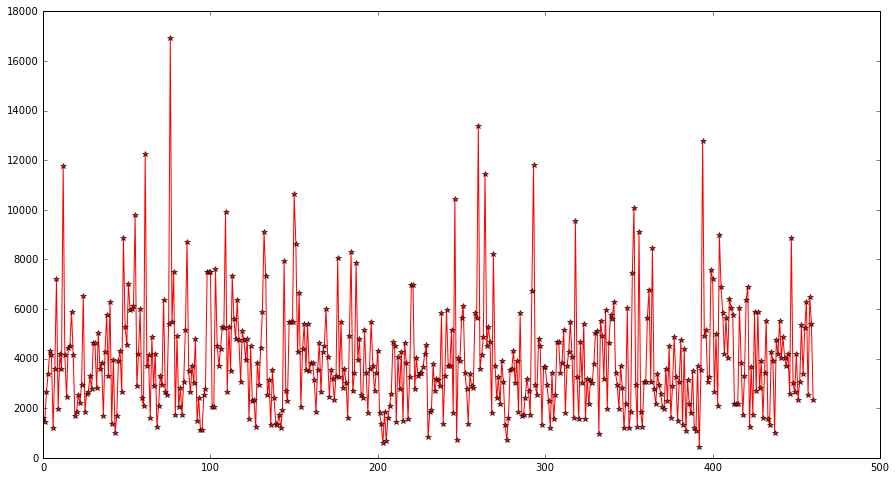

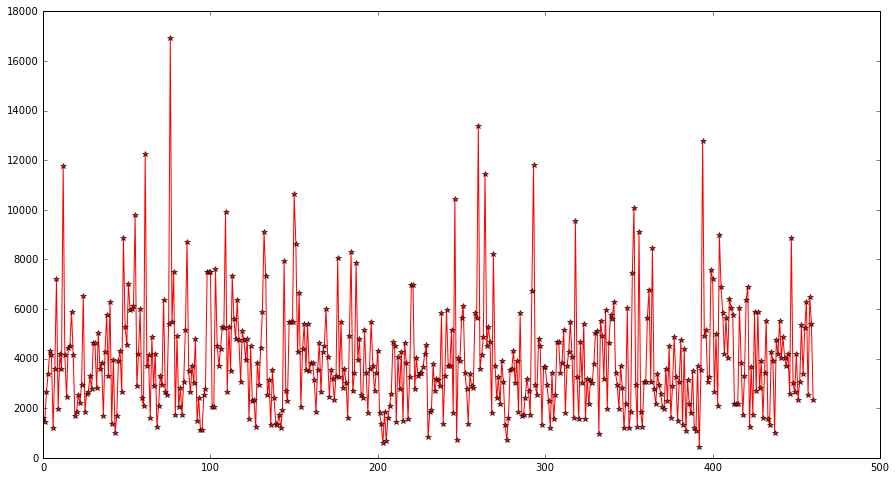

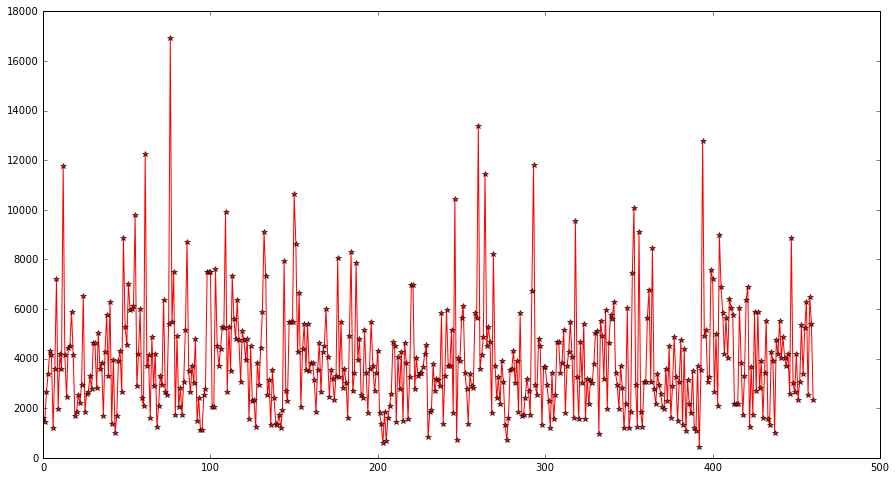

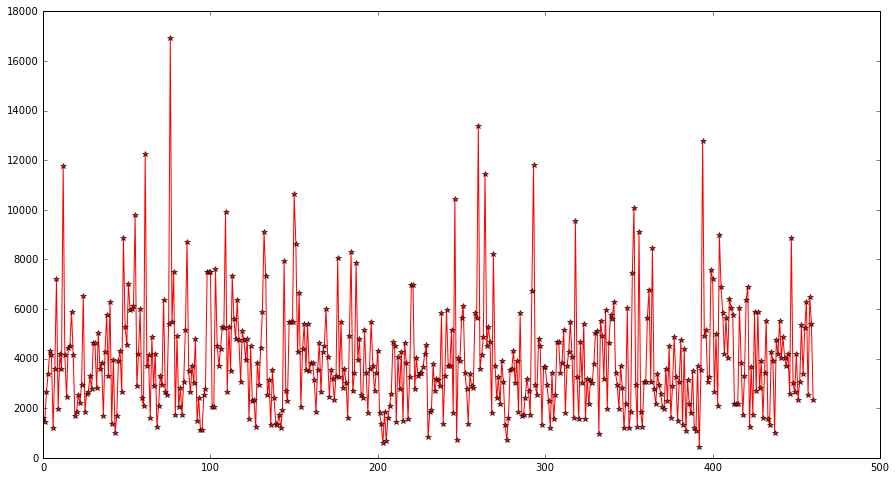

In [128]:
for md in range(1,20):
    print(md)
    model = tree.ExtraTreeRegressor(max_depth=md,min_samples_leaf=ms,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(test[cols])
    print('quality-L1 ',quality(test[target].values, res))
    print('R^2 ',model.score(test[cols],test[target].values))
    print('mape ',mape(list(test[target].values), list(res)))
    print('mean diff in minute ',np.mean((pd.Series(test[target].values) - pd.Series(res))/60))
    plt.figure(figsize=[15,8])
    plt.plot(test[target].values,'-*r')
    print('***')
    #print('TTTTT')
    #plt.plot(res,'*b')

In [ ]:
import sklearn.metrics as mtr

df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[3:df.shape[0]-1]

lrs = []
ests = []
max_depths = []
qs = []

for learning_rate in tqdm(range(1,301,5)):
    learning_rate = learning_rate / 1000.
    for est in tqdm(list(range(1,10))+list(range(10,100,10))+list(range(100,500,50))+list(range(500,1001,100))):
        strs = []
        for max_depth in list(range(1,10))+list(range(10,50,5))+list(range(50,150,10)):
        #for max_depth in tqdm(list(range(1,10))):
            model = ens.GradientBoostingRegressor(learning_rate = learning_rate,
                                                  n_estimators=est,max_depth=max_depth,random_state=42)
            res = cv.cross_val_predict(model, df_temp[cols],df_temp[target].values,cv = 5,n_jobs=-1)
            q = quality(df_temp[target],res)
            
            qs.append(q)
            lrs.append(learning_rate)
            ests.append(est)
            max_depths.append(max_depth)
            
            strs.append([q,learning_rate,est,max_depth])
            
        d = {'quality':qs,'learning_rate':lrs,'est':ests,'max_depth':max_depths}
        df_result = pd.DataFrame(d)
        df_result.to_csv('result_of_research(GradientBoostingRegressor).csv',index = False)
        #print(t.tabulate(strs))

# Градиентный бустинг

In [256]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [257]:
import xgboost as xgb

In [261]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [367]:
def report(grid_scores, n_top=3,score = 'я не помню, что поставил'):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print('"'+str(score)+": {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mse"]}

clf = ens.RandomForestRegressor()
# run randomized search
n_iter_search = 1000

In [336]:

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring='r2',n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
report(random_search.grid_scores_,3, 'R^2')

Model with rank: 1
"mean: 0.19396, std: 0.00202, params: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 9}: 0.194 (std: 0.002)
Parameters: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 9}

Model with rank: 2
"mean: 0.19376, std: 0.00832, params: {'max_depth': 3, 'min_samples_split': 7, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 9}: 0.194 (std: 0.008)
Parameters: {'max_depth': 3, 'min_samples_split': 7, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 9}

Model with rank: 3
"mean: 0.19209, std: 0.01592, params: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: 0.192 (std: 0.016)
Parameters: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False,

In [337]:
from sklearn.metrics import fbeta_score, make_scorer

quality-L1  0.38454055994257
R^2  0.0670392264407
mape  48.62025956109785
mean diff in minute  24.101912260967385


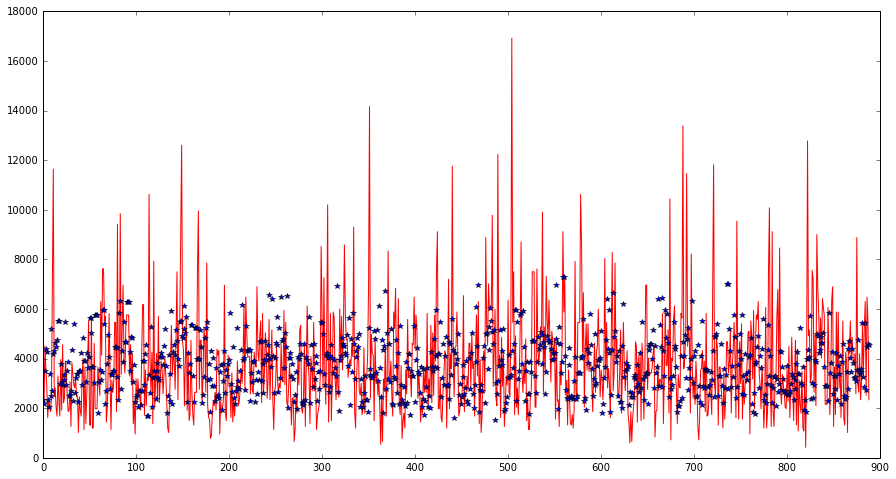

In [361]:
clf = ens.RandomForestRegressor(max_depth = None, min_samples_split= 3, criterion = 'mse',
                                min_samples_leaf = 1, bootstrap = False, max_features = 8)
clf.fit(train[cols],train[target].values)
res =clf.predict(test[cols])
print('quality-L1 ',quality(test[target].values, res))
print('R^2 ',clf.score(test[cols],test[target].values))
print('mape ',mape(list(test[target].values), list(res)))
print('mean diff in minute ',np.mean(np.abs((pd.Series(test[target].values) - pd.Series(res)))/60))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(res,'*b')    

In [355]:
loss_mape  = make_scorer(mape, greater_is_better=False)
loss_L1  = make_scorer(quality, greater_is_better=False)
loss_mean_err = make_scorer(lambda x,y: np.mean(np.abs((pd.Series(x) - pd.Series(y))/60)), greater_is_better=False)

In [339]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_mape,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 178.10 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -55.18421, std: 0.62427, params: {'max_depth': None, 'min_samples_split': 2, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 10}: -55.184 (std: 0.624)
Parameters: {'max_depth': None, 'min_samples_split': 2, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 10}

Model with rank: 2
"mean: -55.28417, std: 1.56070, params: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 10}: -55.284 (std: 1.561)
Parameters: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 10}

Model with rank: 3
"mean: -55.36481, std: 1.22897, params: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 8}: -55.365 (std: 1.229)
Parameters: {'max_de

In [368]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_mean_err,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 162.11 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -21.15568, std: 0.57757, params: {'max_depth': None, 'min_samples_split': 6, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 6}: -21.156 (std: 0.578)
Parameters: {'max_depth': None, 'min_samples_split': 6, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 6}

Model with rank: 2
"mean: -21.16626, std: 0.42703, params: {'max_depth': 3, 'min_samples_split': 9, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: -21.166 (std: 0.427)
Parameters: {'max_depth': 3, 'min_samples_split': 9, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}

Model with rank: 3
"mean: -21.21727, std: 0.55686, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 10}: -21.217 (std: 0.557)
Parameters: {'max_dep

In [341]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_L1,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 180.96 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -0.37372, std: 0.00663, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: -0.374 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}

Model with rank: 2
"mean: -0.37551, std: 0.00922, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 7}: -0.376 (std: 0.009)
Parameters: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 7}

Model with rank: 3
"mean: -0.37573, std: 0.00564, params: {'max_depth': 3, 'min_samples_split': 5, 'criterion': 'mse', 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 10}: -0.376 (std: 0.006)
Parameters: {'max_depth': 

# Neural Network

import theano
import theano.tensor as T

rng = np.random
N = train.shape[0]
#Количество столбцов
feats = len(cols)
#Количество тренировочных шагов
training_steps = 10000

# Декларируем символьные переменные Theano 
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(feats), name="w")
b = theano.shared(0., name="b")

X = train[cols]
Y = train[target].values
min_ = min(Y)
max_ = max(Y)
Y = (Y-min_)/(max_-min_)

# Создаем «выражение» Theano
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))           # Вероятность того, что результат равен  1
prediction = p_1                                   # Порог для прогнозирования
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Функция ошибки для перекрестной энтропии
cost = xent.mean() + 0.01 * (w ** 2).sum()  # Стоимость минимизации
gw,gb = T.grad(cost, [w, b])                          # Рассчитываем градиент стоимости
                                          
# Компилируем «выражение» Theano
train_ = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=prediction)

# Тренировка модели
for i in tqdm(range(training_steps)):
    pred, err = train_(X, Y)

#Прогнозирование
P = predict(test[cols])
#Сохраняем в файл

In [ ]:
from pybrain.tools.shortcuts import buildNetwork

In [ ]:
net = buildNetwork(len(cols), 10, 1)

In [ ]:
net.activate(np.random.random(len(cols)))

In [ ]:
from pybrain.datasets import SupervisedDataSet

In [ ]:
def normalization(df, cols):
    df_res = pd.DataFrame()
    df_res['Arrive'] = df.Arrive
    for i in cols:
        temp = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))
        df_res[i] = temp
    temp = (df['time_of_expected'] - min(df['time_of_expected']))/(max(df['time_of_expected']) - min(df['time_of_expected']))
    df_res['time_of_expected'] = temp
    df_res = df_res.set_index(df.index)
    return df_res

In [ ]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
df_norm = normalization(df_temp,cols)
date_threshold = datetime.strptime('15.03.2015','%d.%m.%Y')
train_norm = df_norm[df_norm.Arrive < date_threshold]
test_norm = df_norm[df_norm.Arrive >= date_threshold]
train_norm = train_norm.sort_values('Arrive')
test_norm = test_norm.sort_values('Arrive')

In [ ]:
ds = SupervisedDataSet(len(cols), 1)
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    y = (train_norm.loc[i,target])
    ds.addSample(X,y)

In [ ]:
len(ds['input'])

In [ ]:
import pybrain.supervised.trainers as trn

In [ ]:
trainer = trn.BackpropTrainer(net, ds,learningrate=0.05)

In [ ]:
err = trainer.trainUntilConvergence(maxEpochs=1000, verbose = 100)

In [ ]:
plt.plot(err[0])

In [ ]:
res = []
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(train_norm[target].values, res))
print('mape ',mape(list(train_norm[target].values), list(res)))
plt.plot(train_norm[target].values,'r')
plt.plot(res,'b')

In [ ]:
res = []
for i in tqdm(test.index):
    X = list(test.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(test[target].values, res))
print('mape ',mape(list(test[target].values), list(res)))
plt.plot(test[target].values,'r')
plt.plot(res,'b')

# END of Networks

# Смотрю штуки всякие

- без аутлаеров (более 10 тысяч секунд на процедуру) получает вполне себе такая симпатичная диаграммка

In [ ]:
temp = df['time_of_procedure']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(temp[:-3],bins = 30)

In [ ]:
a = plt.hist(df.len_of_queque, bins = 5)

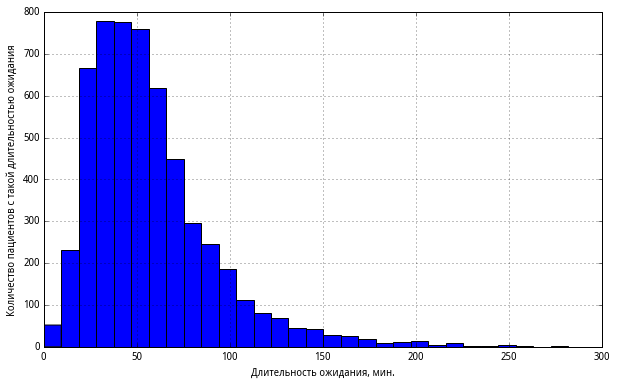

In [76]:
temp = df['time_of_expected']
plt.figure(figsize=[10,6])
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(pd.Series(temp[3:-3])/60,bins = 30)
plt.grid(True)
plt.xlabel('Длительность ожидания, мин.')
plt.ylabel('Количество пациентов с такой длительностью ожидания')

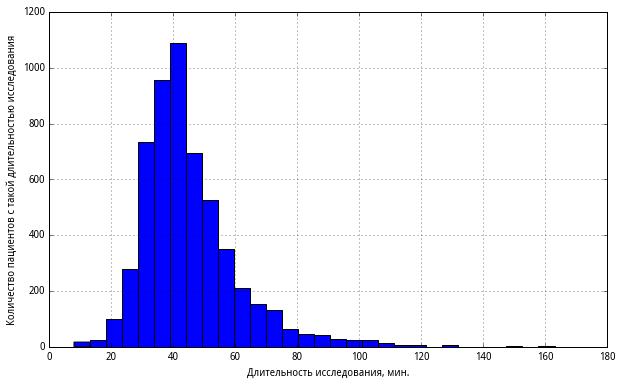

In [71]:
plt.figure(figsize=[10,6])
temp = df['time_of_procedure']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(pd.Series(temp[3:-3])/60,bins = 30)
plt.grid(True)
plt.xlabel('Длительность исследования, мин.')
plt.ylabel('Количество пациентов с такой длительностью исследования')

# Estimate result

1. Берем первый элемент df и предсказываем для него 

# Ideas

1. Предсказывать для каждого прихода время ожидания + время проведения исследования и использовать это как фичи
2. Брать среднее от линейной регрессии и какого нибудь бустинга